# COURSE: Neural signal processing and analysis: Zero to hero
## SESSION: Problem set: Simulating and visualizing data
### TEACHER: Mike X Cohen, sincxpress.com

---

## Instructions:
The goal of this assignment is to simulate time series data that can be used to test time-series analysis methods. For each section below:
1. Complete the MATLAB code
2. Put the data into the EEG structure - Make sure all relevant fields are accurate (EEG.data, EEG.pnts, EEG.trials, EEG.srate, EEG.nbchan, EEG.times)
3. Plot the data using the function `plot_simEEG()`

**NOTE 1:** Obviously, you need to fill in missing code.
**NOTE 2:** Be careful, because sometimes there is incorrect code that doesn't produce coding errors. Remember: Visualize, and visualize often.

---

### 1) white noise

The goal of this exercise is to gain basic familiarity with data simulations. You will create a dataset of white noise and plot it.


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from attributedict.collections import AttributeDict
from scipy.fft import fft, ifft
from utils import *

In [8]:
EEG = AttributeDict()

In [9]:
# specify EEG parameters
EEG.srate  = 500 # sampling rate in Hz
EEG.pnts   = 1000
EEG.trials = 30
EEG.nbchan = 10

# time vector
EEG.times = np.arange(0, EEG.pnts)/EEG.srate


# create data as white noise
EEG.data = 10* np.random.randn(EEG.nbchan, EEG.pnts, EEG.trials) # from normal distribution
# EEG.data = np.random.uniform(size=(EEG.nbchan, EEG.pnts, EEG.trials)) # from uniform distribution

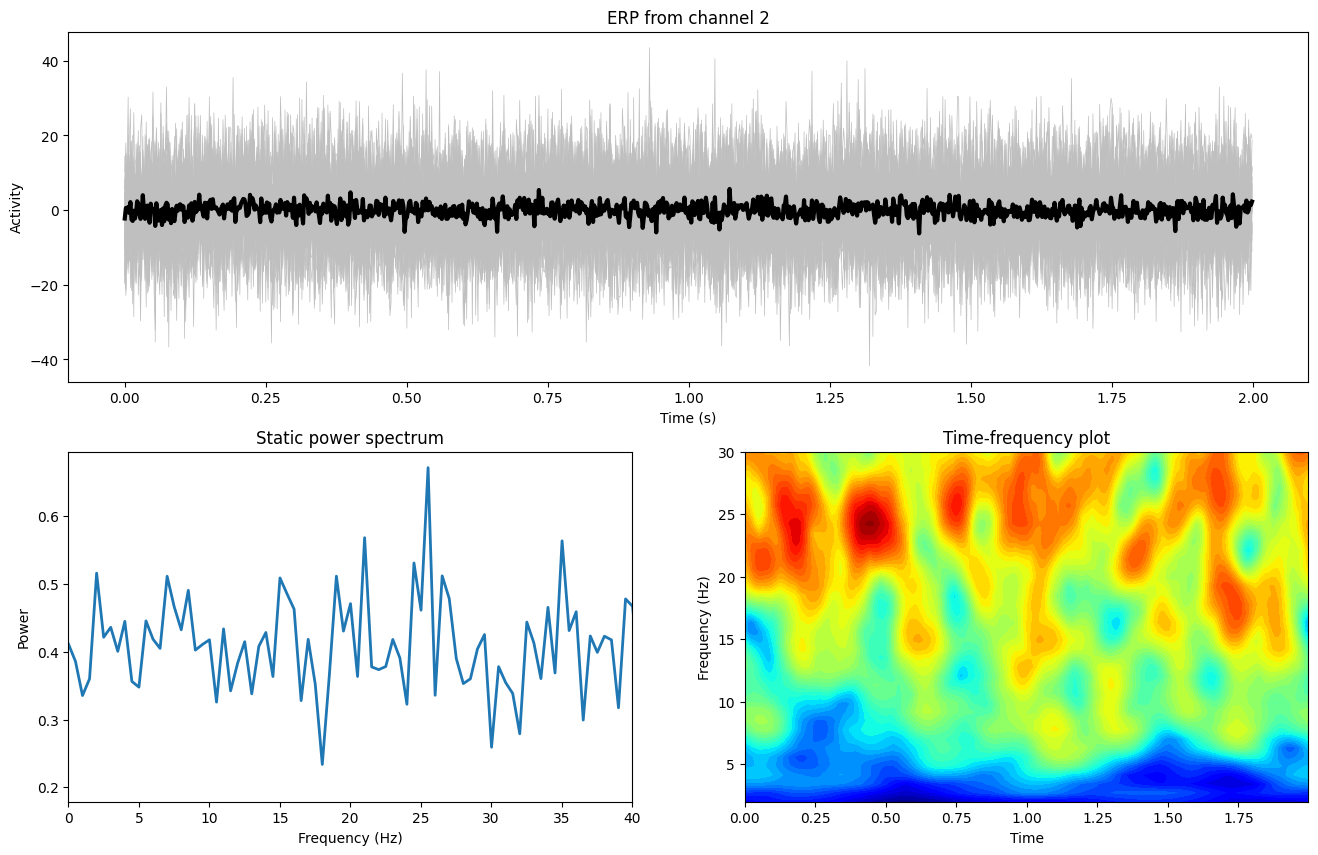

In [10]:
plot_simEEG(EEG,2,1)

#### Question: What is the effect of noise amplitude on the resulting graphs?
#### Question: Do the results change if you use normally distributed vs. uniformly distributed noise?
#### Question: Are the results different for different channels? Why or why not?

# 2) Pink Noise

The goal of this exercise is to extend the previous exercise to "pink" noise.
You should create the noise separately on each trial


In [12]:
# feel free to change some parameters compared to above...
EEG.nbchan = 4

# the key parameter of pink noise is the exponential decay (ed)
ed = 50 # try different values!

# initialize EEG data as a zeros matrix
EEG.data = np.zeros((EEG.nbchan, EEG.pnts, EEG.trials))

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        
        # generate one-sided 1/f amplitude spectrum
        as_ = np.random.rand(1, EEG.pnts) * np.exp(-np.arange(EEG.pnts)/ed)
        
        # Fourier coefficients as amplitudes times random phases
        fc = as_ * np.exp(1j * 2 * np.pi * np.random.rand(*as_.shape))
        
        # inverse Fourier transform to create the noise
        EEG.data[chani,:,triali] = np.real(np.fft.ifft(fc))

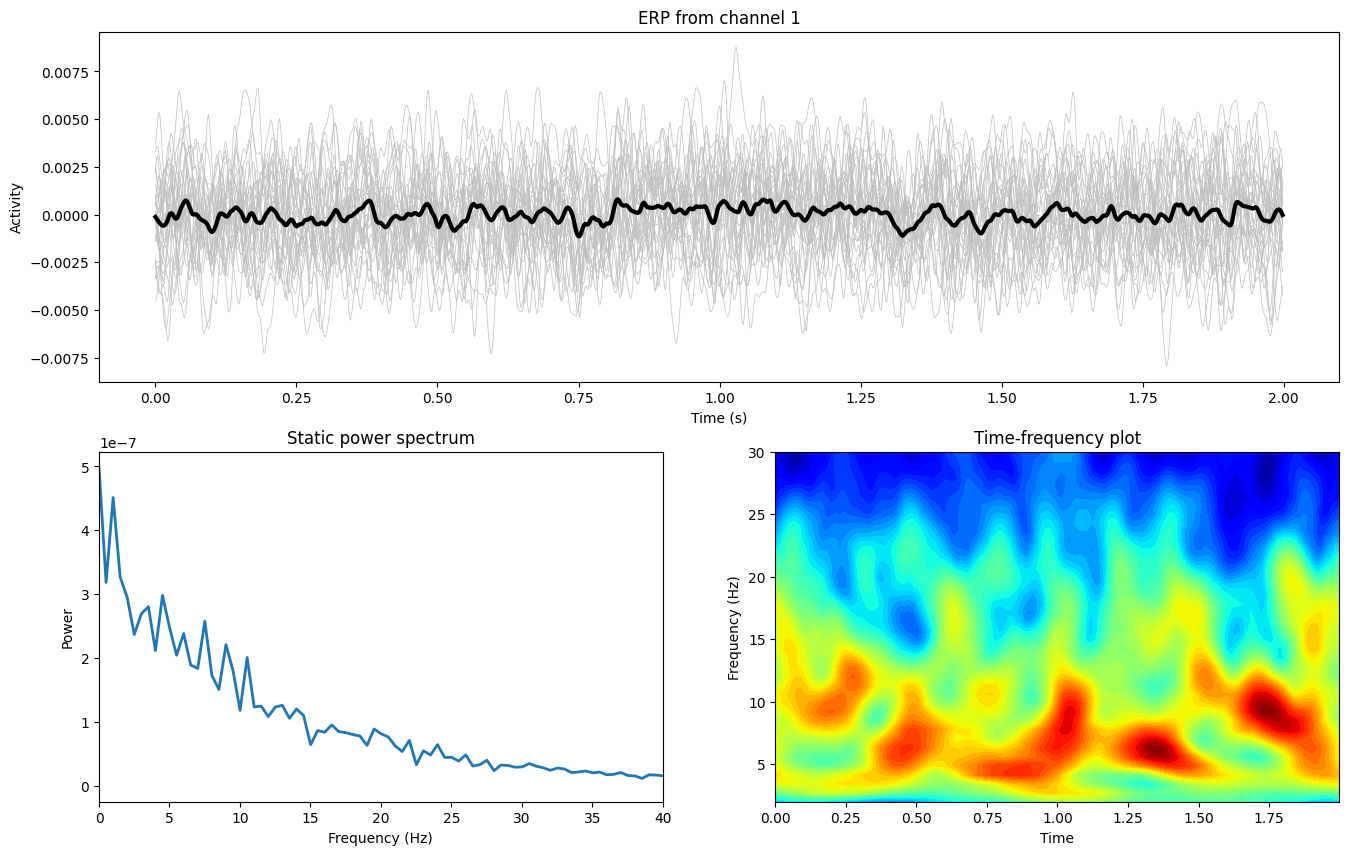

In [13]:
# and plot
plot_simEEG(EEG,1,2)

Question: Which looks more like real EEG data: white or pink noise?
Why do you think this is?<br>

Question: Which values of variable 'ed' make the data look most like real EEG data?

# 3) Ongoing stationary
 The goal here is to create a dataset with ongoing sinewaves.
 There should be multiple sine waves simultaneously in each channel/trial.

In [14]:
# list of frequencies and corresponding amplitudes
frex = [ 3, 5, 16 ] # in Hz
amps = [ 3, 4, 5  ] # in arbitrary units

In [15]:
for chan in range(EEG.nbchan):
    for trial in range(EEG.trials):
        # Note that here the signal is created in the time domain, unlike in the previous example.
        #   Some signals are easier to create in the time domain; others in the frequency domain.
        phase = np.random.normal()
        # create a multicomponent sine wave
        sinewave = np.zeros((1,EEG.pnts))
        for si in range(len(frex)):
            sinewave = sinewave + amps[si]*np.sin(2*np.pi*frex[si]*EEG.times + phase) 
        
        # data as a sine wave plus noise
        EEG.data[chan,:,trial] = sinewave + np.random.randn(*sinewave.shape)

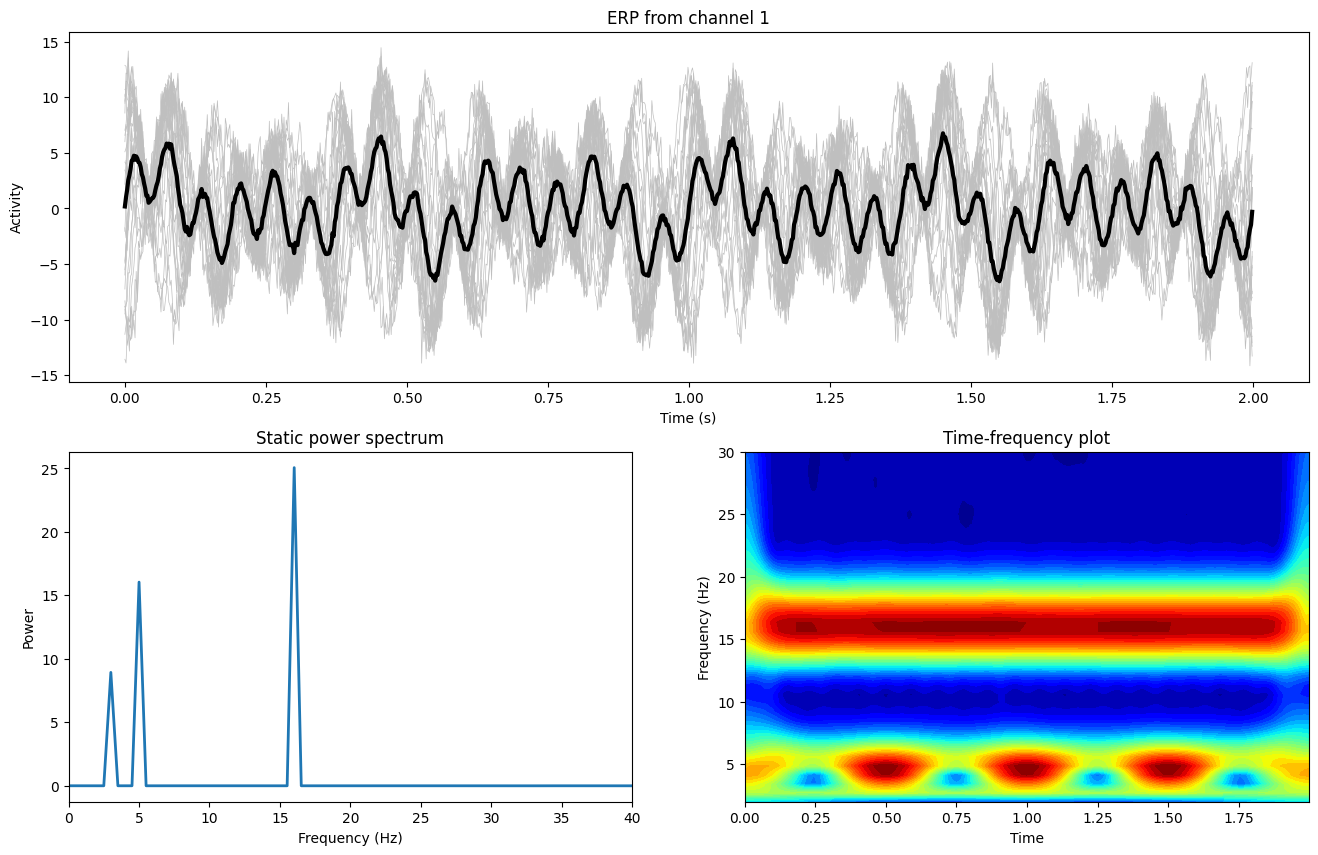

In [16]:
# and plot
plot_simEEG(EEG,1,2)

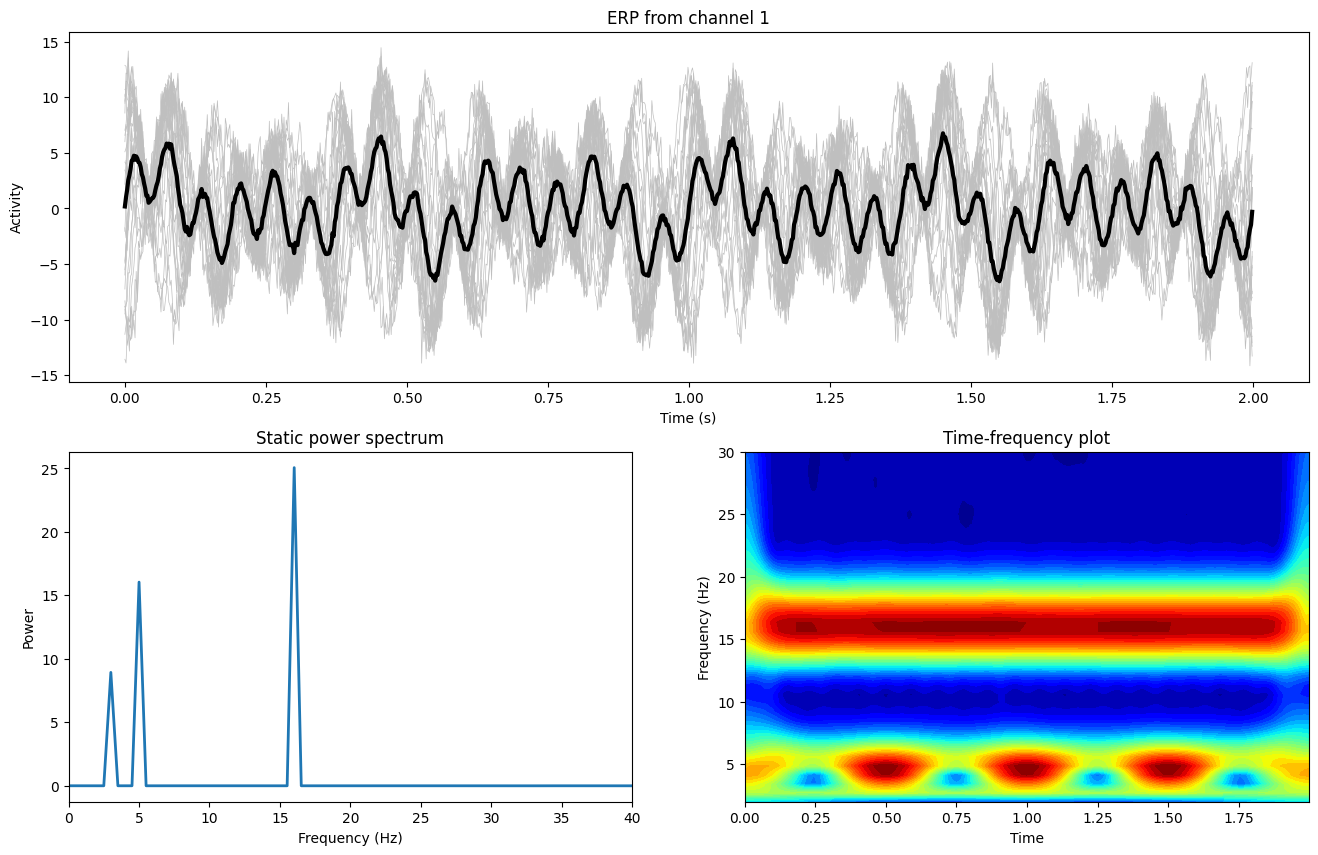

In [17]:
# and plot
plot_simEEG(EEG,1,2)

 Question: What can you change in the code above to make the EEG
             activity non-phase-locked over trials?
             
 Question: Which of the plots look different for phase-locked vs. non-phase-locked?
             (Hint: plot them in different figures to facilitate comparison.)
             Are you surprised about the differences?
             
 Question: Are all frequencies equally well represented in the 'static' and 'dynamic' power spectra?
             Can you change the parameters to make the spectral peaks more or less visible in the two plots?

# 4) Ongoing nonstationary

 Here you want to create narrowband non-stationary data. 
 This is starting to be more "realistic" (in a signal-characteristic sense) for EEG data.

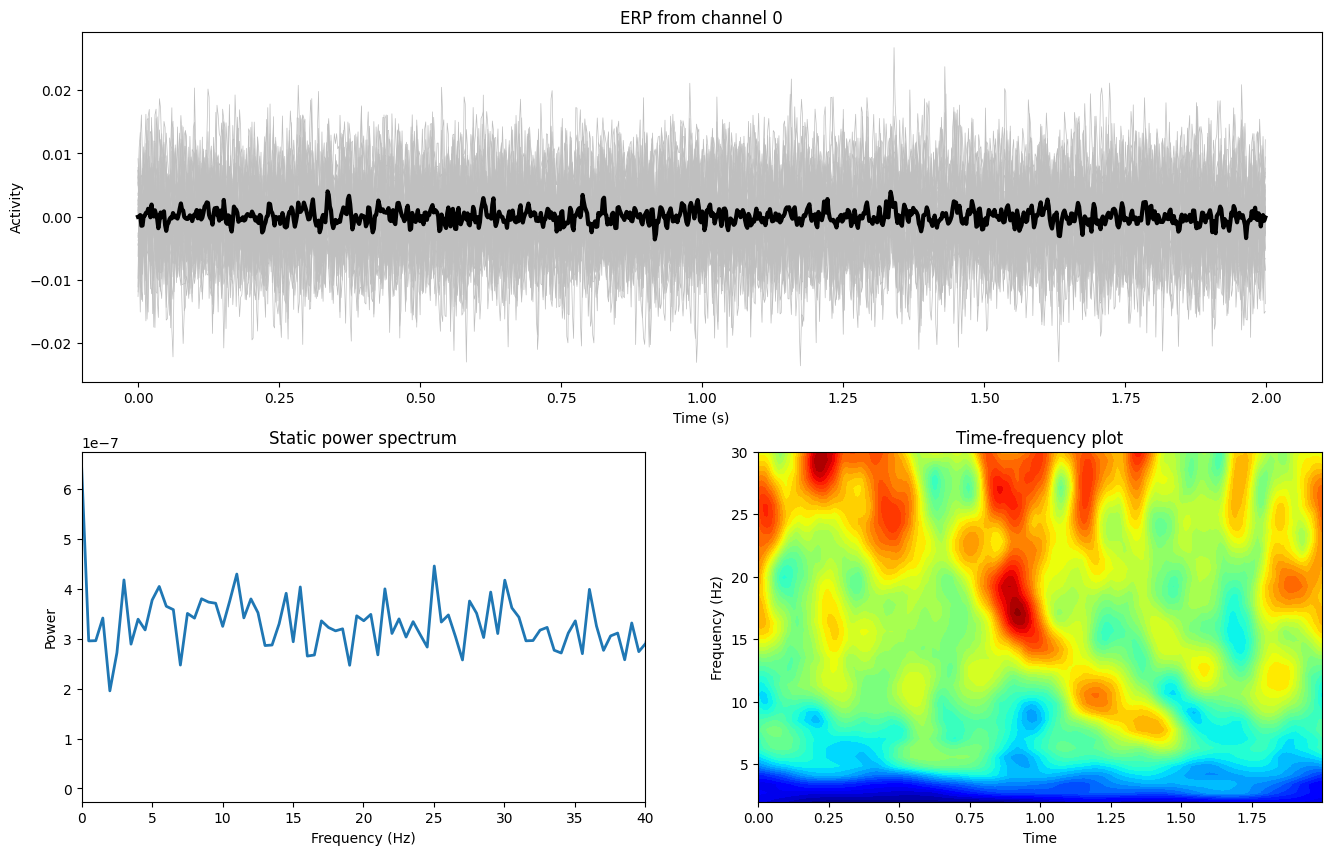

In [18]:
# signal parameters in Hz
peakfreq = 14
fwhm     =  269

# frequencies
hz = np.linspace(0,EEG.srate,EEG.pnts)


# create frequency-domain Gaussian
s  = fwhm*(2*np.pi-1)/(4*np.pi) # normalized width
x  = hz-peakfreq         # shifted frequencies
fg = np.exp(-0.5*(x/s)**2)   # gaussian


for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        
        # As with previous simulations, don't worry if you don't understand the mechanisms;
        #   that will be clear tomorrow. Instead, you can plot each step to try to build intuition.
        
        # Fourier coefficients of random spectrum
        fc = np.random.rand(1,EEG.pnts) * np.exp(1j*2*np.pi*np.random.rand(1,EEG.pnts))
        
        # taper Fourier coefficients by the Gaussian
        fc = fc * fg
        
        # go back to time domain to get EEG data
        EEG.data[chani,:,triali] = np.real(np.fft.ifft(fc))
        
plot_simEEG(EEG)

 Question: What is the effect of FWHM on the results? Is larger or smaller more realistic?<br>
 Question: Can you modify the code to have narrowband activity at two different frequency ranges?

# 5) Transients #1: Gaussian

 All the exercises above were for ongoing signals. Now we move to transients.
 Start with a Gaussian.

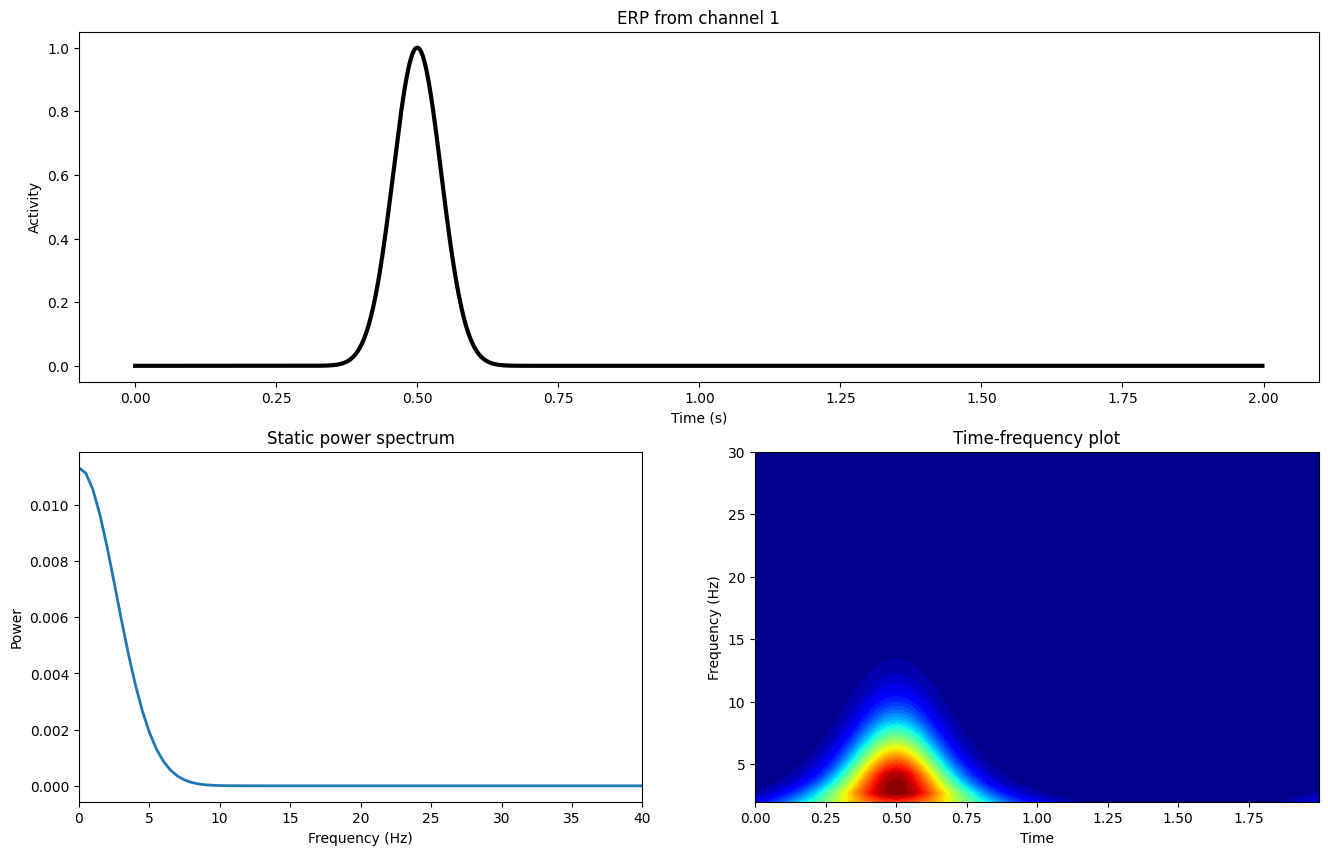

In [19]:
# gaussian parameters (in seconds)
peaktime = 0.5
width = 0.1

# re-initialize EEG data
EEG.data = np.zeros((EEG.nbchan,EEG.pnts,EEG.trials))

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        
        # generate time-domain gaussian
        trialpeak = peaktime
        gaus =  np.exp(-4*np.log(2)*(EEG.times - trialpeak)**2 / width**2)
        
        # data are the Gaussian
        EEG.data[chani,:,triali] = gaus
        
plot_simEEG(EEG,1,1)

 Questions: What happens if you add random jitter to the peaktime on each trial? 
              How much jitter until the ERP is nearly gone?

# 6) transients #2: oscillations w/ Gaussian

 Finally, we get to the most useful simulations for time-frequency analysis:
   time-limited narrow-band activity. This is done by multiplying a Gaussian with a sine wave.


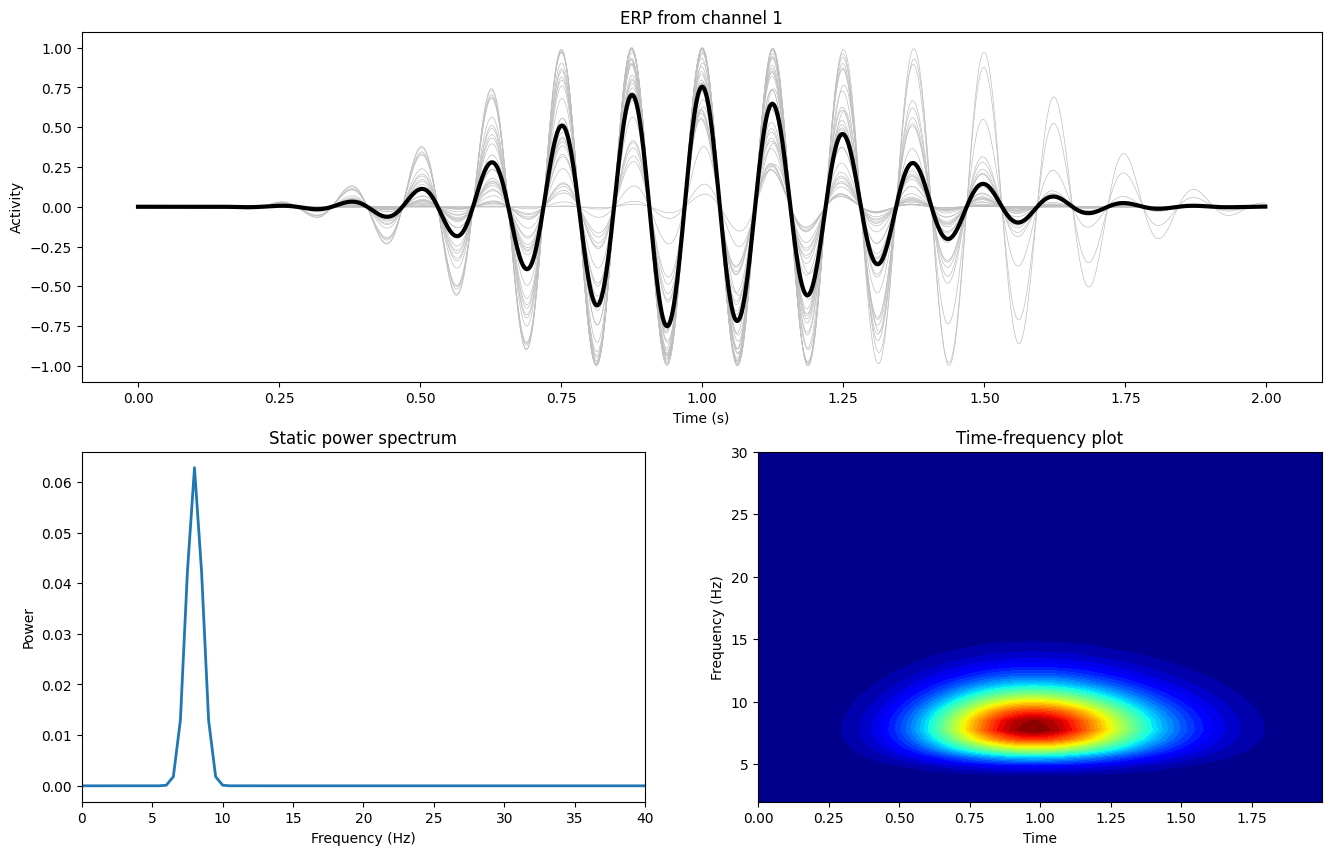

In [20]:
# sine wave frequency
sfreq = 8

# gaussian parameters (in seconds)
peaktime = 1
width = .2

# re-initialize EEG data
EEG.data = np.zeros((EEG.nbchan, EEG.pnts, EEG.trials))

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        
        # generate time-domain gaussian
        trialpeak = peaktime + np.random.randn()/5
        gaus = np.exp(-(EEG.times - trialpeak)**2 / (2 * width**2))
        
        # generate sine wave with same phase
        sw = np.cos(2 * np.pi * sfreq* EEG.times)
        
        # data are sine wave times Gaussian
        EEG.data[chani,:,triali] = gaus * sw

plot_simEEG(EEG,1,1)

 Question: Do the results look realistic? What can you change to make it look even more EEG-like?
           
 Question: How can you modify the code to make the transient non-phase-locked?
            Which of the three data plots are most affected by phase-locked vs. non-phase-locked?

# 7) Add pink noise to #5

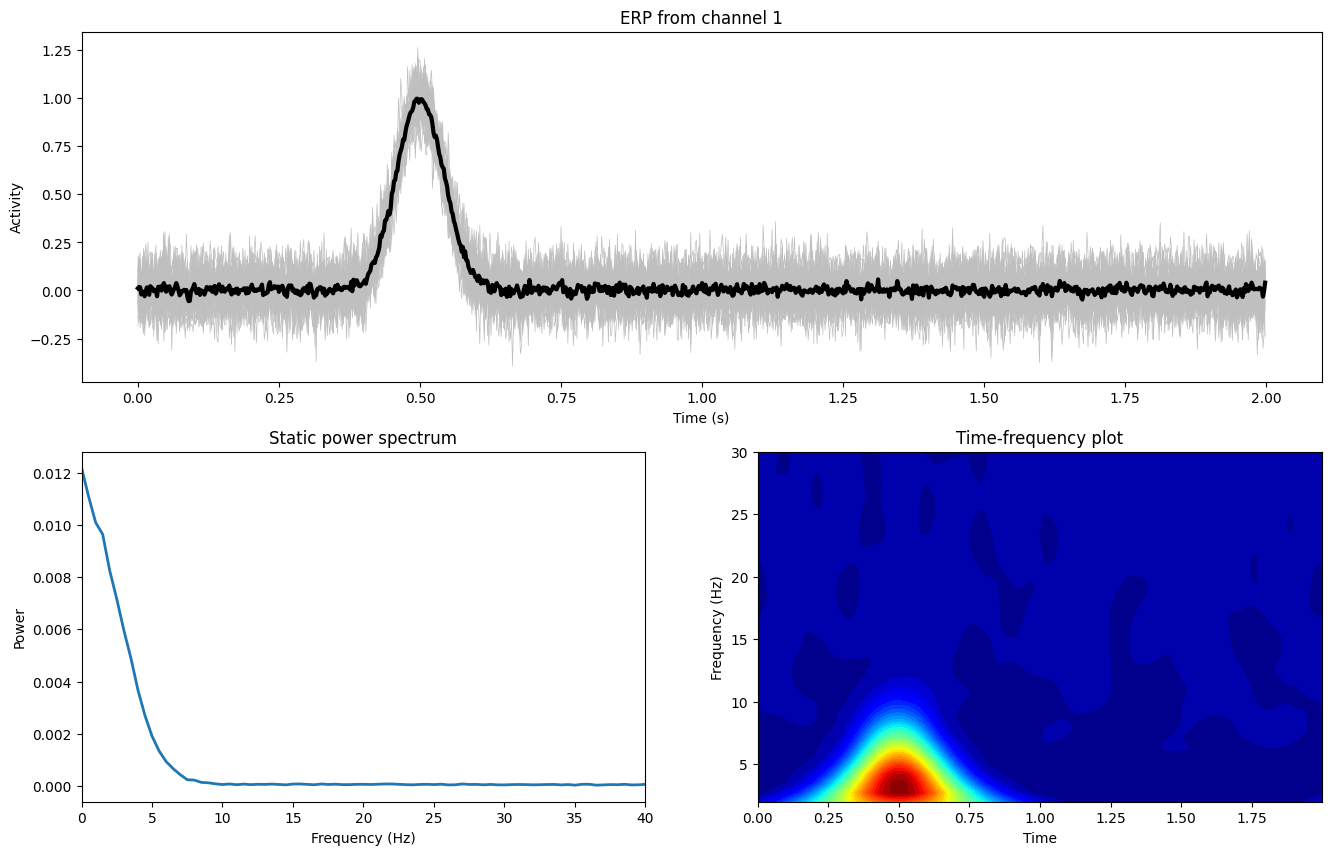

In [21]:
# gaussian parameters (in seconds)
peaktime = 0.5
width = 0.1
ed = 500

# re-initialize EEG data
EEG.data = np.zeros((EEG.nbchan,EEG.pnts,EEG.trials))

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        
        # generate one-sided 1/f amplitude spectrum
        as_ = np.random.rand(1, EEG.pnts) * np.exp(-np.arange(EEG.pnts)/ed)
        # Fourier coefficients as amplitudes times random phases
        fc = as_ * np.exp(1j * 2 * np.pi * np.random.rand(*as_.shape))
        # inverse Fourier transform to create the noise
        pink_noise = np.real(np.fft.ifft(fc))
        
        # generate time-domain gaussian
        trialpeak = peaktime
        gaus =  np.exp(-4*np.log(2)*(EEG.times - trialpeak)**2 / width**2)
        
        # data are the Gaussian
        EEG.data[chani,:,triali] = gaus + pink_noise*15
        
plot_simEEG(EEG,1,1)